<a href="https://colab.research.google.com/github/bingsen-wang/PowerElectronics/blob/main/Rectifier_3phaseFullBridge_diode_leakageIndcutances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Three-Phase Full-Brdige Diode Rectifier with Leakage Inductances</h1></b>

Dr. Bingsen Wang

3/30/2024
</center>

#Python Code
The Python code illustrates waveforms of the three-phase full-bridge diode rectifier.

<ipython-input-3-a0e5ad72dc14>:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


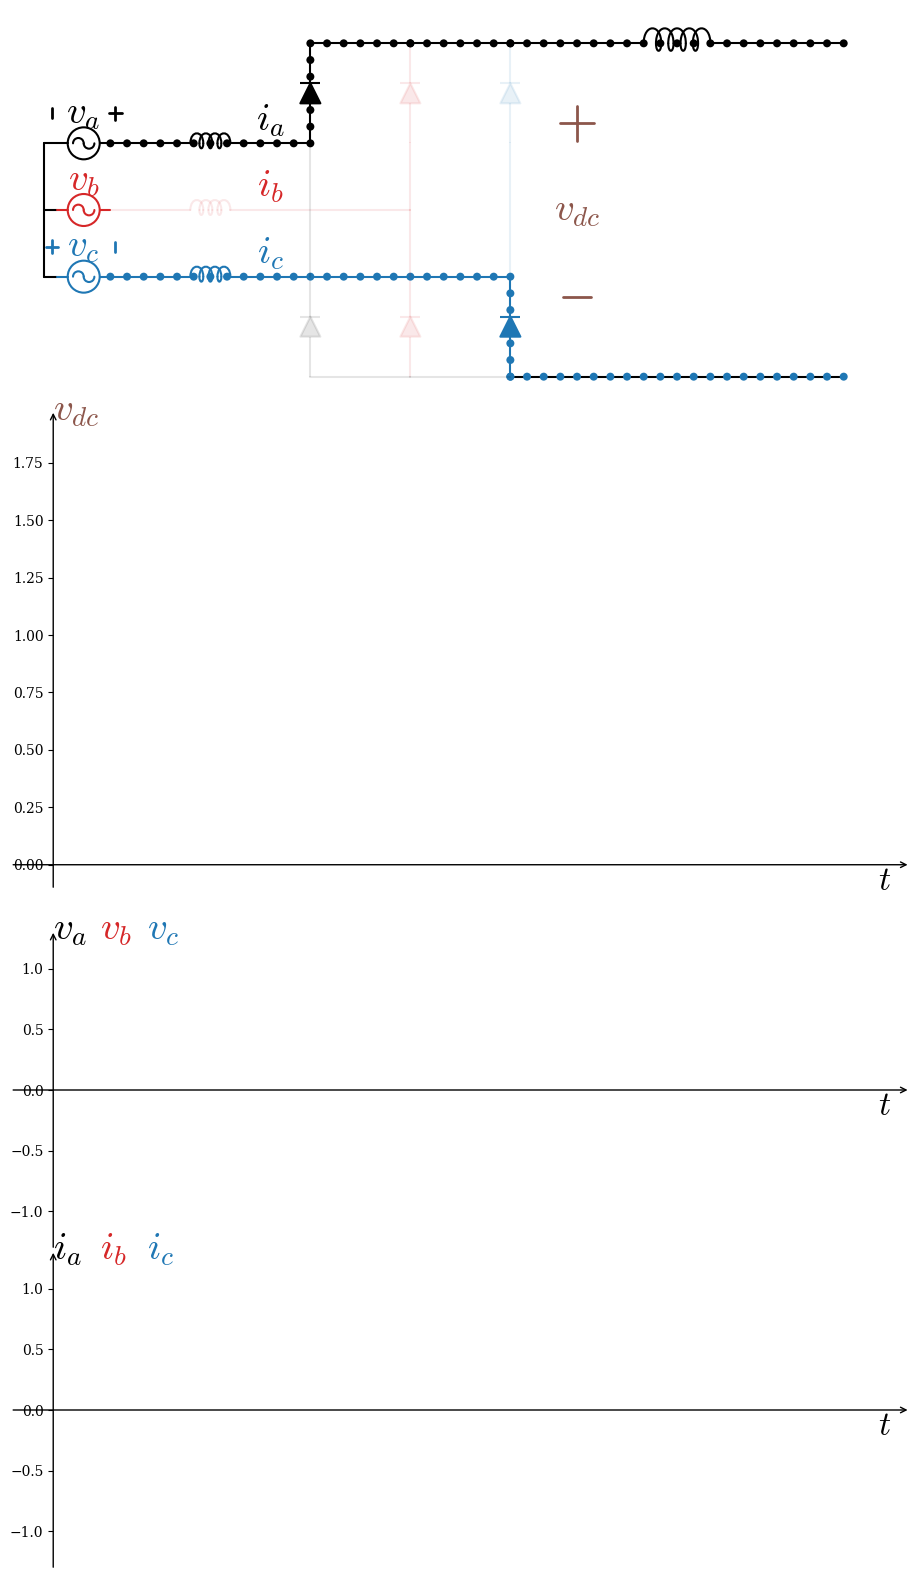

In [ ]:
import matplotlib
from os import linesep
import numpy as np
from numpy import linspace,cos,sin,pi,heaviside,fft,array,sqrt
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba, to_hex, to_rgb
from matplotlib.path import Path
import matplotlib.patches as mp
from matplotlib.collections import PatchCollection
from matplotlib import animation,rc,transforms
rc('animation', html='jshtml')
plt.rcParams.update({"font.family" : "serif","mathtext.fontset" : "cm"})

#modulation functions
def mf(t,f,phi):
  mta = cos(2*pi*f*t+phi)
  mtb = cos(2*pi*f*t+phi-2*pi/3)
  mtc = cos(2*pi*f*t+phi+2*pi/3)
  return [mta,mtb,mtc]

#switching functions for the high-side diodes
def hh(mt):
  hta = heaviside(mt[0]-mt[1],0)*heaviside(mt[0]-mt[2],0)
  htb = heaviside(mt[1]-mt[2],0)*heaviside(mt[1]-mt[0],0)
  htc = heaviside(mt[2]-mt[0],0)*heaviside(mt[2]-mt[1],0)
  return [hta,htb,htc]

#switching functions for the low-side diodes
def hl(mt):
  hta = heaviside(mt[1]-mt[0],0)*heaviside(mt[2]-mt[0],0)
  htb = heaviside(mt[2]-mt[1],0)*heaviside(mt[0]-mt[1],0)
  htc = heaviside(mt[0]-mt[2],0)*heaviside(mt[1]-mt[2],0)
  return [hta,htb,htc]

#commutation intervals for high side
def commh(t,f,phi,tc,hht):
  comm_h = heaviside((t-tc+(phi+pi/3)/(2*pi*f))%(1/(3*f))-(t+(phi+pi/3)/(2*pi*f))%(1/(3*f)), 0)
  return [comm_h*hht[0],comm_h*hht[1],comm_h*hht[2]]

#commutation intervals for low side
def comml(t,f,phi,tc,hlt):
  comm_l = heaviside((t-tc+phi/(2*pi*f))%(1/(3*f))-(t+phi/(2*pi*f))%(1/(3*f)), 0)
  return [comm_l*hlt[0],comm_l*hlt[1],comm_l*hlt[2]]

#commutation current, rising
def icommr(t,f,phi,tc,hht):
  wt = (2*pi*f*t+phi)%(pi/3)
  wtc = 2*pi*f*tc
  icomm = (1-cos(wt))/(1-cos(wtc))
  return icomm

#commutation current, falling
def icommf(t,f,phi,tc,hht):
  wt = (2*pi*f*t+phi)%(pi/3)
  wtc = 2*pi*f*tc
  icomm = 1- (1-cos(wt))/(1-cos(wtc))
  return icomm

#high-side diode current
def ihdiode(t,f,phi,tc,hht):
  ih = [] #high side current
  for k in range(3):
    ihk = hht[k]+commh(t,f,phi,tc,hht)[(k+1)%3]*icommf(t,f,phi,tc,hht) #falling edge
    ihk += commh(t,f,phi,tc,hht)[k]*(icommr(t,f,phi,tc,hht)-1) #rising edge
    ih.append(ihk)
  return ih

#low-side diode current
def ildiode(t,f,phi,tc,hlt):
  il = [] #high side current
  for k in range(3):
    ilk = hlt[k]+comml(t,f,phi,tc,hlt)[(k+1)%3]*icommf(t,f,phi,tc,hlt) #falling edge
    ilk += comml(t,f,phi,tc,hlt)[k]*(icommr(t,f,phi,tc,hlt)-1) #rising edge
    il.append(ilk)
  return il

#ac current
def iac(t,f,phi,tc,hht,hlt):
  i = [] #high side current
  for k in range(3):
    i.append(ihdiode(t,f,phi,tc,hht)[k] - ildiode(t,f,phi,tc,hlt)[k])
  return i

#dc voltage
def vdc(t,f,phi,tc,hht,hlt):
  vh = 0
  vl = 0
  for k in range(3):
    vh += commh(t,f,phi,tc,hht)[k]*(0.5*(mf(t,f,phi)[k]+mf(t,f,phi)[(2+k)%3]))
    vh += (hht[k] - commh(t,f,phi,tc,hht)[k])*(mf(t,f,phi)[k])
    vl += comml(t,f,phi,tc,hlt)[k]*(0.5*(mf(t,f,phi)[k]+mf(t,f,phi)[(2+k)%3]))
    vl += (hlt[k] - comml(t,f,phi,tc,hlt)[k])*(mf(t,f,phi)[k])
  return vh-vl

#draw diode symbol
def drawDiode(ax,x0,y0,h,theta,lw,color):
  codes=[Path.MOVETO,Path.LINETO]
  p1=mp.PathPatch(Path([(x0,y0),(x0,y0+h*0.4), (x0,y0+h*0.6),(x0,y0+h)],
                       codes+codes))
  p2=mp.PathPatch(Path([(x0-h*0.1,y0+h*0.6),(x0+h*0.1,y0+h*0.6)],
                       codes)) #cathode
  p3=mp.PathPatch(Path([(x0,y0+h*0.6),(x0-h*0.1,y0+h*0.4),(x0+h*0.1,y0+h*0.4),(x0,y0+h*0.6)],
                       [Path.MOVETO,Path.LINETO,Path.LINETO,Path.CLOSEPOLY])) #anode
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  kwargs=dict({'ec':color,'fc':['none','none',color],'lw':lw,'transform':rot})
  ax.add_collection(PatchCollection([p1,p2,p3],**kwargs))
  return

#draw inductor symbol
def drawInductor(ax,x0,y0,n,h,w,theta,lw,color):
  """n: number of coils;  h: height or width; lw: line weight
  theta: orientation 0 for horizontal 90 for vertical """
  w= w/(0.7*n+0.3)#width of larger coil
  plg, psm = ([],[]) #the half coil with larger curvature
  codes=[Path.MOVETO,Path.CURVE4,Path.CURVE4,Path.CURVE4]
  verts=[(x0,y0),(x0,y0+0.4*h),(x0+w,y0+0.4*h),(x0+w,y0)]
  for k in range(n):
    if k==0:
      plg.append(mp.PathPatch(Path(verts,codes)))
    else:
      p = Path([(x0 + 0.7*k*w,y0),(x0 + 0.7*k*w,y0+0.4*h),
                (x0+(0.7*k+1)*w,y0+0.4*h),(x0+(0.7*k+1)*w,y0)], codes)
      plg.append(mp.PathPatch(p))
      p = Path([(x0 + 0.7*k*w,y0),(x0 + 0.7*k*w,y0-0.2*h),
                (x0+(0.7*k+0.3)*w,y0-0.2*h),(x0+(0.7*k+0.3)*w,y0)], codes)
      psm.append(mp.PathPatch(p))
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  pc=PatchCollection(np.concatenate((plg,psm)),ec=color,fc='none',lw=lw,transform=rot,capstyle='round')
  ax.add_collection(pc)
  return


#draw ac voltage source symbol
def drawVoltSourceAc(ax,x0,y0,h,theta,lw,color):
  """ x0,y0: top or left end of the voltage source lead
  h: height or width; lw: line weight
  theta: orientation 0 for horizontal 90 for vertical"""
  ps=[] # container of the zig-zags
  codes=[Path.MOVETO,Path.LINETO,Path.MOVETO,Path.LINETO]
  p = Path([(x0,y0),(x0+.2*h,y0),(x0+.8*h,y0),(x0+h,y0)],codes)
  ps.append(mp.PathPatch(p))
  ps.append(mp.Circle((x0+.5*h,y0),.3*h))
  ps.append(mp.Arc((x0+.4*h,y0),.2*h,.2*h,theta2=180))
  ps.append(mp.Arc((x0+.6*h,y0),.2*h,.2*h,theta1=180))
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  pc=PatchCollection(ps,ec=color,fc='none',lw=lw,transform=rot,capstyle='round')
  ax.add_collection(pc)
  return

#draw the +/- voltage polarity with variable distance/color
def drawVoltSign(ax,x0,y0,h,theta,lw,color):
  """
  x0,y0: center between "+" and "-"
  h: height or width
  theta: orientation 0 for horizontal 90 for vertical
  lw: line weight
  """
  p = Path([(x0-0.5*h,y0-0.1*h),(x0-0.5*h,y0+0.1*h),(x0-0.6*h,y0),(x0-0.4*h,y0),
            (x0+0.5*h, y0-0.08*h),(x0+0.5*h, y0+0.08*h)],
           [Path.MOVETO,Path.LINETO,Path.MOVETO,Path.LINETO,
            Path.MOVETO,Path.LINETO])
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  ax.add_patch(mp.PathPatch(p,ec=color,fc='none',lw=lw,transform=rot,capstyle='round'))
  return

#combine rgb colors with weights
def combine_rgb_values(d):
  r,g,b=0,0,0
  for k in range(len(d)):
    r += d[k][0][0]*d[k][1]
    g += d[k][0][1]*d[k][1]
    b += d[k][0][2]*d[k][1]
  return (r,g,b)

#moving dots for current flow, only works for horizontal and vertical lines
def drawMovingDots(ax,path,space,n_steps,nth_step,rdot,color):
  i = 0
  dx0 = path[1][0] - path[0][0]
  dy0 = path[1][1] - path[0][1]
  x0 = path[0][0] + nth_step*space/n_steps*(2*heaviside(dx0,0.5)-1)
  y0 = path[0][1] + nth_step*space/n_steps*(2*heaviside(dy0,0.5)-1)
  while i<len(path)-1:
    dx = path[i+1][0] - path[i][0]
    dy = path[i+1][1] - path[i][1]
    ax.add_patch(mp.Circle([x0,y0],radius=rdot,fc=color))
    x0 += space*(2*heaviside(dx,0.5)-1)
    y0 += space*(2*heaviside(dy,0.5)-1)
    if (path[i+1][0] - x0)*dx < 0:
      if i+2<len(path):
        dy1 = path[i+2][1] - path[i+1][1]
      else:
        dy1 = 0
      y0 = path[i+1][1] + abs(x0 - path[i+1][0])*(2*heaviside(dy1,0.5)-1)
      x0 = path[i+1][0]
      i += 1
    elif (path[i+1][1]-y0)*dy < 0:
      if i+2<len(path):
        dx1 = path[i+2][0] - path[i+1][0]
      else:
        dx1 = 0
      x0 = path[i+1][0] + abs(y0 - path[i+1][1])*(2*heaviside(dx1,0.5)-1)
      y0 = path[i+1][1]
      i += 1
  return

#draw non-animated parts of the circuitry
def drawRectifierNa(ax,lw,clst,txlst):
  args = dict({'lw':lw,'capstyle':
               'round', 'fc':'None'})
  args1=  dict({'size':28,'va':'center'})
  codes=[Path.MOVETO,Path.LINETO,Path.LINETO,Path.LINETO]
  x = -5
  for k in range(3):
    p1 = Path([(x,1-k), (x+.2,1-k)], codes[0:2])
    ax.add_patch(mp.PathPatch(p1,**args))
    drawVoltSourceAc(ax,x+.2,1-k,.8,0,lw,clst[k+1])
    ax.text(x+.6,1.45-k, txlst[1][0][k],color=clst[1+k],ha='center',**args1) #va,b,c
    ax.text(x+3.4,1.35-k, txlst[2][0][k],color=clst[1+k],ha='center',**args1) #ia,b,c
  p2 = Path([(x+7,2.5), (x+9,2.5), (x+10,2.5), (x+12,2.5)],
            codes[0:2]+codes[0:2]) #positive dc rail
  p3 = Path([(x+7,-2.5),(x+12,-2.5)], codes[0:2]) #negative dc rail
  p4 = Path([(x,1), (x,-1)], codes[0:2]) #source neutral vertical
  ax.add_patch(mp.PathPatch(p2,**args))
  ax.add_patch(mp.PathPatch(p3,**args))
  ax.add_patch(mp.PathPatch(p4,**args))
  drawInductor(ax,x+9,2.5,5,.75,1,0,lw,'k') #dc inductor
  ax.text(x+8,0,txlst[0][0],color=clst[0],ha='center',**args1) #vdc
  return

#draw animated parts of the circuitry
def drawRectifierAnim(ax,i_ani,iht,ilt,vac,vdc,lw,clst):
  x=-5
  args = dict({'lw':lw,'capstyle':'round', 'fc':'None'})
  codes=[Path.MOVETO,Path.LINETO,Path.LINETO]
  ctbch1 = [[to_rgb(clst[1]),iht[0]], [to_rgb(clst[2]),iht[1]], [to_rgb(clst[3]),iht[2]]] #colors to be combined #high side
  ctbcl1 = [[to_rgb(clst[1]),ilt[0]], [to_rgb(clst[2]),ilt[1]], [to_rgb(clst[3]),ilt[2]]] #colors to be combined #low side

  for k in range(3):
    drawDiode(ax,x+4+1.5*k,1,1.5,0,lw,to_rgba(clst[1+k],max(iht[k],0.1))) #high-side
    drawDiode(ax,x+4+1.5*k,-2.5,1.5,0,lw,to_rgba(clst[1+k],max(ilt[k],0.1))) #low-side
    p2 = Path([(x+1,1-k), (x+2.2,1-k), (x+2.8,1-k), (x+4+k*1.5,1-k)],
              codes[0:2]+codes[0:2])
    ax.add_patch(mp.PathPatch(p2,color=to_rgba(clst[1+k],max(ilt[k],iht[k],0.1)),**args))
    drawInductor(ax,x+2.2,1-k,4,.5,.6,0,lw,to_rgba(clst[1+k],max(ilt[k],iht[k],0.1))) #ac inductor
    drawVoltSign(ax,x+.6,1.45-k,1.1*vac[k],180,2,clst[k+1]) #va sign
    if iht[k]>0:
      if k==0:
        p_points = [[x+1,1-k],[x+4+1.5*k,1-k],[x+4+1.5*k,2.5],[x+4+1.5,2.5]]
      else:
        p_points = [[x+1,1-k],[x+4+1.5*k,1-k],[x+4+1.5*k,2.5]]
      drawMovingDots(ax,p_points,0.25,20,i_ani%20,.06*iht[k],clst[1+k])
    if ilt[k]>0:
      if k==0:
        n_points = [[x+1,1-k],[x+4+1.5*k,1-k],[x+4+1.5*k,-2.5],[x+4+1.5,-2.5]]
      else:
        n_points = [[x+1,1-k],[x+4+1.5*k,1-k],[x+4+1.5*k,-2.5]]
      drawMovingDots(ax,n_points[::-1],0.25,20,i_ani%20,.06*ilt[k],clst[1+k])
  drawMovingDots(ax,[[x+7,2.5],[x+12,2.5]],0.25,20,i_ani%20,.06,combine_rgb_values(ctbch1))
  drawMovingDots(ax,[[x+5.5,2.5],[x+7,2.5]],0.25,20,i_ani%20,.06*(iht[0]+iht[1]),combine_rgb_values(ctbch1))
  drawMovingDots(ax,[[x+12,-2.5],[x+7,-2.5]],0.25,20,i_ani%20,.06,combine_rgb_values(ctbcl1))
  drawMovingDots(ax,[[x+7,-2.5],[x+5.5,-2.5]],0.25,20,i_ani%20,.06*(ilt[0]+ilt[1]),combine_rgb_values(ctbcl1))
  p3 = Path([(x+4,1), (x+4,-1)], codes[0:2]) #vertical phase-a
  p4 = Path([(x+5.5,1), (x+5.5,0)], codes[0:2]) #vertical phase-b
  p5 = Path([(x+5.5,-1), (x+5.5,0)], codes[0:2])#vertical phase-b
  p6 = Path([(x+7,1), (x+7,-1)], codes[0:2]) #vertical phase-c
  p7 = Path([(x+4,2.5), (x+5.5,2.5)], codes[0:2]) #horizontal pos-ab
  p8 = Path([(x+7,2.5), (x+5.5,2.5)], codes[0:2]) #horizonatal pos-bc
  p9 = Path([(x+4,-2.5), (x+5.5,-2.5)], codes[0:2]) #horizontal neg-ab
  p10 = Path([(x+7,-2.5), (x+5.5,-2.5)], codes[0:2]) #horizonatal neg-bc
  ax.add_patch(mp.PathPatch(p3,color=to_rgba(clst[1],max(ilt[0],0.1)),**args))
  ax.add_patch(mp.PathPatch(p4,color=to_rgba(clst[2],max(iht[1],0.1)),**args))
  ax.add_patch(mp.PathPatch(p5,color=to_rgba(clst[2],max(ilt[1],0.1)),**args))
  ax.add_patch(mp.PathPatch(p6,color=to_rgba(clst[3],max(iht[2],0.1)),**args))
  ax.add_patch(mp.PathPatch(p7,color=to_rgba('k',max(iht[0],0.1)),**args))
  ax.add_patch(mp.PathPatch(p8,color=to_rgba('k',max(iht[0]+iht[1],0.1)),**args))
  ax.add_patch(mp.PathPatch(p9,color=to_rgba('k',max(ilt[0],0.1)),**args))
  ax.add_patch(mp.PathPatch(p10,color=to_rgba('k',max(ilt[0]+ilt[1],0.1)),**args))
  drawVoltSign(ax,x+8,0,1.5*vdc,-90,2,clst[0]) #vdc sign
  return

#parameters
f=1
Nf = 600
t=linspace(0,1,Nf)
tmax = max(t)
phi = 30*pi/180
Tc = 10/(360*f)#communtation interval
mt = mf(t,f,phi) #time domain modulation functions
hht = hh(mt)
hlt = hl(mt)
iht = ihdiode(t,f,phi,Tc,hht) #high-side currents
ilt = ildiode(t,f,phi,Tc,hlt) #low-side currents
iact = iac(t,f,phi,Tc,hht,hlt) #ac current
vdct = vdc(t,f,phi,Tc,hht,hlt) #dc voltage
#set up figures
fig = plt.figure(figsize=(9,16)) #overall plot area
km = 1.1 # margin
ax_frame = [[(0,.725 , 1, .25),[-5.5,8],[-3,3]], #circuit diagram
            [(0,.725 , 1, .25),[-5.5,8],[-3,3]], #animated circuit
            [(0, .425 , 1, .3),[-.05*km,1*km],[-.1*km,1.8*km]], #v_dc
            [(0,.2 , 1, .2),[-.05*km,1*km],[-1.2*km,1.2*km]], #v_ac
            [(0,0 , 1, .2),[-.05*km,1*km],[-1.2*km,1.2*km]], #v_ac
            ]# [pos-boundary, xlim, ylim] for subplots
ax_lst=[] #axis list or the list of subplots
ax_lbl=[
        ['$v_{dc}$', '$t$'],
        [['$v_{a}$','$v_{b}$','$v_{c}$'], '$t$'],
        [['$i_{a}$','$i_{b}$','$i_{c}$'], '$t$'],
        ] #variables for yx axes of each subplot
clst=['tab:brown','k','tab:red','tab:blue'] #list of colors used for plots
text_tls = [] #place holder for titles of each plot updated during animation

#draw axes and label them for each subplot and setup the plot lines
lines = [] #array containing all the line segments
for k in range(len(ax_frame)):
  ax=fig.add_axes(ax_frame[k][0],xlim=ax_frame[k][1], ylim=ax_frame[k][2],
                  fc='none') #remove frame face color
  if k<2:
    ax.axis('off') #turn the first 2 axes for circuit digram completely off
  else: #the rest axes
    ax.spines[:].set_visible(False) #set all spines off
    ax.spines['left'].set_position(('data', 0)) #set spines to cross zero
    ax.set_xticks([]) #set x-axis ticks off
    xmin,xmax,ymin,ymax=np.concatenate((ax_frame[k][1],ax_frame[k][2]))
    ax.annotate("", xy=(xmax, 0), xytext=(xmin, 0),
          arrowprops=dict(arrowstyle="->")) #draw x-axis with arrow
    ax.annotate("", xy=(0,ymax), xytext=(0,ymin),
          arrowprops=dict(arrowstyle="->")) #draw y-axis with arrow
    ax.text(xmax-0.025,0,ax_lbl[k-2][-1],
            size=24,va='top',ha='right',color='k') #label x axis of subplot
    if k==2:
      ax.text(0,ymax,ax_lbl[0][0],size=28,va='center',color=clst[k-2])
      lines.append(ax.plot([],[],color=clst[k-2],lw=4)[0])
    else:
      for kk in range(len(ax_lbl[k-2][0])):
        ax.text(kk*0.06,ymax,ax_lbl[k-2][0][kk],size=28,va='center',color=clst[kk+1])
        lines.append(ax.plot([],[],color=clst[1+kk],lw=3)[0])

  ax_lst.append(ax)
fig.tight_layout()


# animation function. This is called sequentially
def animate(i):
  print(i) #for monitoring
  lines[0].set_data(t[0:i]/tmax,vdct[0:i])
  for k in range(3):
    lines[1+k].set_data(t[0:i]/tmax,mt[k][0:i])
    # lines[4+k].set_data(t[0:i]/tmax,ilt[k][0:i])
    lines[4+k].set_data(t[0:i]/tmax,iact[k][0:i])

  ax_lst[1].clear()
  ax_lst[1].set_xlim(ax_frame[1][1])
  ax_lst[1].set_ylim(ax_frame[1][2])
  ax_lst[1].axis('off')
  drawRectifierAnim(ax_lst[1],i,array(iht)[:,i],array(ilt)[:,i],array(mt)[:,i],vdct[i],1.5,clst)
  return

drawRectifierNa(ax_lst[0],1.5,clst,ax_lbl)
anim = animation.FuncAnimation(fig, animate, frames=Nf, interval=50)
writervideo = animation.FFMpegWriter(fps=30)
anim.save('rectifier_3ph_leakageInductance.mp4', writer=writervideo,dpi = 240)